In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from dongnet import dongnet12

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

CUDA is not available. Training on CPU ...


In [3]:
# Weigth Loss Value
def norm1(X, Y):
    return np.sum(np.abs(X-Y))

def norm2(X, Y):
    return np.sqrt(np.sum(np.square(X-Y)))

In [4]:
model = dongnet12()
model_dict = torch.load('model.pth', map_location=torch.device('cpu'))  # 상태 사전 로드
model.load_state_dict(model_dict)  # 모델에 상태 사전 로드

<All keys matched successfully>

In [5]:
train_transform = transforms.Compose([
        #padding을 4추가하고 이미지를 32 X 32로 자름
        transforms.RandomCrop(32, padding=4),
        #이미지를 뒤집는다
        transforms.RandomHorizontalFlip(),
        #텐서로 바꾼다
        transforms.ToTensor(),
        #각 채널별 평균, 표준편차``
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # CIFAR10 train 데이터 가져오기
    # We will use test set for validation and test in this project.
    # Do not use test set for validation in practice!
    # CIFAR10 test 데이터 가져오기
train_set = torchvision.datasets.CIFAR100(root="data", train=True, download=True, transform=train_transform) 
test_set = torchvision.datasets.CIFAR100(root="data", train=False, download=True, transform=test_transform)

train_sampler = torch.utils.data.RandomSampler(train_set)
test_sampler = torch.utils.data.SequentialSampler(test_set)

    #sampler은 dataset에서 데이터를 뽑아오는 역할, num_workers는 데이터를 읽어오는 프로세스 수
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=128,
    sampler=train_sampler, num_workers=8)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=256,
    sampler=test_sampler, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


# 모델 한층 분석
2번째 layer인 conv2에 대한 parameter 분석

In [8]:
for name, param in model.named_parameters():
    layername = '.'.join(name.split('.')[:1])
    print(layername)
    if layername == 'conv2':
        conv2 = param.cpu().detach().numpy()

conv1
batchnorm1
batchnorm1
conv2
batchnorm2
batchnorm2
conv3
batchnorm3
batchnorm3
conv4
batchnorm4
batchnorm4
conv5
batchnorm5
batchnorm5
conv6
batchnorm6
batchnorm6
conv7
batchnorm7
batchnorm7
conv8
batchnorm8
batchnorm8
conv9
batchnorm9
batchnorm9
linear_relu
linear_relu
linear_relu
linear_relu
linear_relu
linear_relu


In [9]:
print(conv2.shape)

(64, 64, 3, 3)


In [10]:
print(len(np.unique(conv2)))

36856


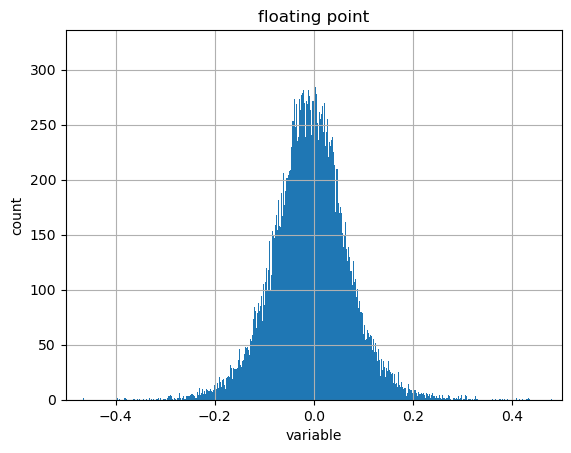

In [11]:
plt.hist(conv2.flatten(), bins=1000)
plt.xlabel('variable')
plt.ylabel('count')
plt.xlim([-0.5, 0.5])
plt.title('floating point')
plt.grid()

# symmetric quantization

In [33]:
# 1. find threshold
NBIT = 8 #quantization bit
alpha = np.max(conv2)
beta = np.min(conv2)
alpha_q = -2**(NBIT - 1)
beta_q = 2**(NBIT - 1) - 1

s = (beta - alpha) / (beta_q - alpha_q)
z = int((beta*alpha_q - alpha * beta_q) / (beta - alpha))

data_q = np.round(1/s * conv2 + z, decimals=0)
data_q = np.clip(data_q, alpha_q, beta_q)
data_q = data_q.astype(np.int8)

data_qn = data_q
data_qn = data_qn.astype(np.int32)
data_qn = s * (data_qn - z)
data_qn = data_qn.astype(np.float32)

207


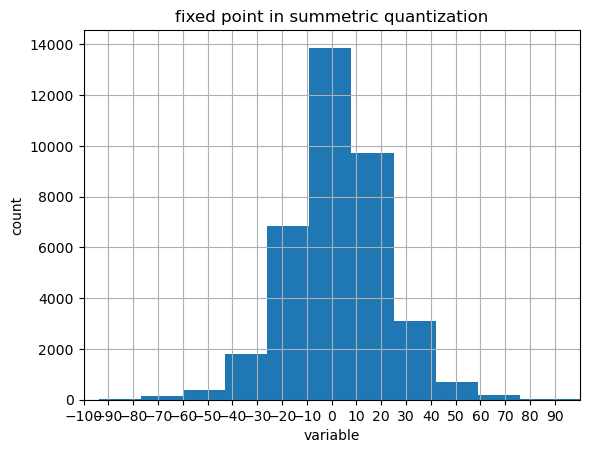

In [50]:
print(len(np.unique(data_q)))
plt.hist(data_q.flatten(), bins=15)
plt.xlabel('variable')
plt.ylabel('count')
plt.xlim([-100, 100])
plt.xticks(np.arange(-100, 100, 10))
plt.title('fixed point in summetric quantization')
plt.grid()
print(da)